In [205]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

In [206]:
# With the following block, we allow displaying resulting images within the notebook:

def plot_image(img, figsize_in_inches=(10,10)):
    fig, ax = plt.subplots(figsize=figsize_in_inches)
    ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()
    
def plot_images(imgs, figsize_in_inches=(10,10)):
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
    for col, img in enumerate(imgs):
        axs[col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

red_color = (0,0,255)

# Original Images

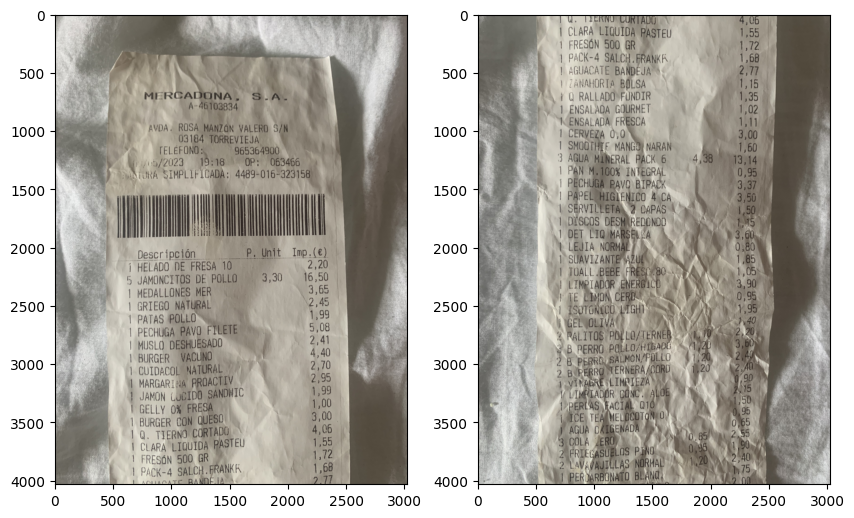

In [207]:
part1_file_name = "LucasWhiteBG1.jpg"
part2_file_name = "LucasWhiteBG2.jpg"
result_file_name = "result.jpg"

part1 = cv.imread(part1_file_name)
part2 = cv.imread(part2_file_name)
plot_images([part1, part2])

# Image Preprocessing

In [208]:
# Resize with Area algorithm
def resize(img, to_width = 1200):
    # initialize the dimensions of the image to be resized and grab the image size
    (h, w) = img.shape[:2]
    print('Original Dimensions: ',img.shape)
    ratio = to_width / float(w)
    new_dimensions = (int(to_width), int(h * ratio))
    resized = cv.resize(img, new_dimensions, interpolation = cv.INTER_AREA)
    print('Resized Dimensions: ', resized.shape)
    return resized

In [209]:
# Resize with Area algorithm
# if part1 is the result already processed with resize do not resize
part1_resized = None
part2_resized = resize(part2)

if part1_file_name == result_file_name:
    part1_resized = part1.copy()
else:
    part1_resized = resize(part1)

Original Dimensions:  (4032, 3024, 3)
Resized Dimensions:  (1600, 1200, 3)
Original Dimensions:  (4032, 3024, 3)
Resized Dimensions:  (1600, 1200, 3)


# Features Detection and Matches Finding

In [210]:
def find_doc_mask(img):
    gray = img.copy()
    if len(img.shape) == 3:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    threshold = 150
    mask = cv.threshold(gray, threshold, 255, cv.THRESH_BINARY)[1]
    return mask

def draw_matches(matches, base_image, sec_image, base_image_kp, sec_image_kp):
    draw_params = dict(matchColor = red_color, singlePointColor = None, flags = 2)
    match = cv.drawMatches(base_image, base_image_kp, sec_image, sec_image_kp, matches, None, **draw_params)
    plot_image(match)

def get_featured_image(img, kp):
    tmp = img.copy()
    img = cv.drawKeypoints(img, kp, tmp, color=red_color, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

def find_matches(base_image, sec_image, threshold, debug_draw, min_matches = 10):
    sift = cv.SIFT_create()
    sec_image_mask = find_doc_mask(sec_image)
    base_image_kp, base_image_des = sift.detectAndCompute(base_image, None)
    sec_image_kp, sec_image_des = sift.detectAndCompute(sec_image, sec_image_mask)

    if debug_draw:
        plot_images([get_featured_image(base_image, kp=base_image_kp), get_featured_image(sec_image, kp=sec_image_kp)])

    brute_force_matcher = cv.BFMatcher()    #  match images can be used either FLANN or BFMatcher methods that OpenCV provides - https://docs.opencv.org/3.1.0/dc/dc3/tutorial_py_matcher.html 
    all_matches = brute_force_matcher.knnMatch(base_image_des, sec_image_des, k=2)  # k=2 return the two best matches for every descriptor

    # filter all matches found to get the best ones
    good_matches = []
    for m, n in all_matches:
        if m.distance < threshold * n.distance:
            good_matches.append(m)

    if len(good_matches) > min_matches:
        if debug_draw:
            draw_matches(good_matches, base_image, sec_image, base_image_kp, sec_image_kp)
        return (good_matches, base_image_kp, sec_image_kp)
    else:
        print("Not enough matches are found - %d/%d" % (len(good_matches), min_matches))
        return None

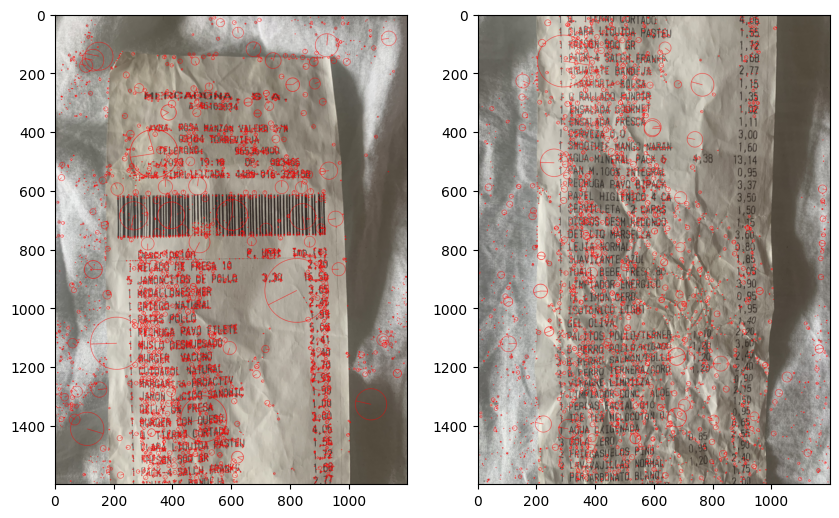

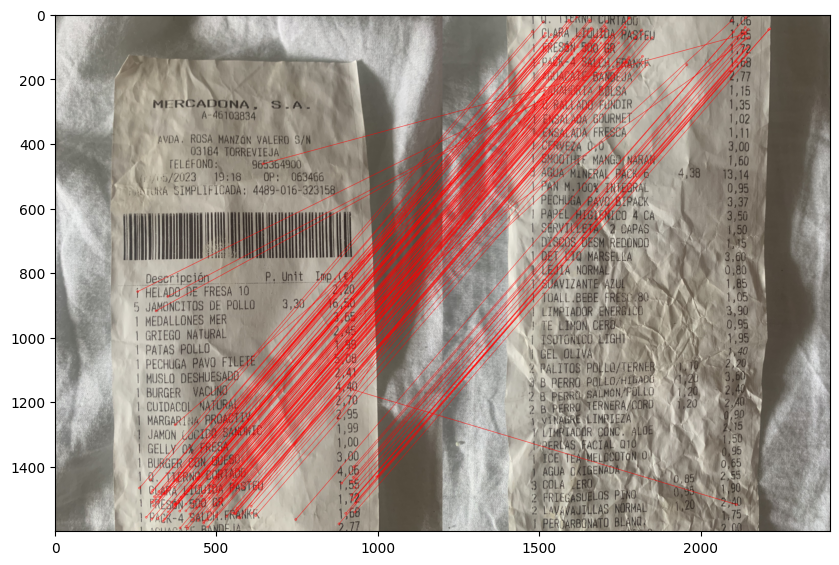

In [211]:
matches, base_image_kp, sec_image_kp = find_matches(part1_resized, part2_resized, threshold=0.5, debug_draw=True)

# Homography Finding

In [212]:
def find_homography(kp1, kp2, matches):
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    (H, _) = cv.findHomography(src_pts, dst_pts, cv.RANSAC, ransacReprojThreshold=15.0)
    return H

In [213]:
H = find_homography(base_image_kp, sec_image_kp, matches)

# Images Stitching and Homography Applying

In [214]:
def new_frame_size_and_matrix(homography, sec_image_shape, base_image_shape):
    # Reading the size of the image
    (height, width) = sec_image_shape
    
    # Taking the matrix of initial coordinates of the corners of the secondary image
    # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
    # Where (xi, yi) is the coordinate of the i th corner of the image. 
    initial_matrix = np.array([[0, width - 1, width - 1, 0],
                                                        [0, 0, height - 1, height - 1],
                                                        [1, 1, 1, 1]])
    
    # Finding the final coordinates of the corners of the image after transformation.
    # NOTE: Here, the coordinates of the corners of the frame may go out of the 
    # frame(negative values). We will correct this afterwards by updating the 
    # homography matrix accordingly.
    final_matrix = np.dot(homography, initial_matrix)

    [x, y, c] = final_matrix
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the stitched image frame and the "Correction" factor
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    new_width = max_x
    new_height = max_y
    correction = [0, 0]

    if min_x < 0:
        new_width -= min_x
        correction[0] = abs(min_x)
    if min_y < 0:
        new_height -= min_y
        correction[1] = abs(min_y)
    
    # Again correcting New_Width and New_Height
    # Helpful when secondary image is overlaped on the left hand side of the Base image.
    if new_width < base_image_shape[1] + correction[0]:
        new_width = base_image_shape[1] + correction[0]
    if new_height < base_image_shape[0] + correction[1]:
        new_height = base_image_shape[0] + correction[1]

    # Finding the coordinates of the corners of the image if they all were within the frame.
    x = np.add(x, correction[0])
    y = np.add(y, correction[1])
    old_initial_points = np.float32([[0, 0],
                                    [width - 1, 0],
                                    [width - 1, height - 1],
                                    [0, height - 1]])
    new_final_ponts = np.float32(np.array([x, y]).transpose())

    # Updating the homography matrix. Done so that now the secondary image completely 
    # lies inside the frame
    new_homography = cv.getPerspectiveTransform(old_initial_points, new_final_ponts)
    
    return [new_height, new_width], correction, new_homography

def stitchImages(base_image, sec_image, homography):
    # Finding size of new frame of stitched images and updating the homography matrix 
    new_frame_size, correction, homographyMatrix = new_frame_size_and_matrix(homography, sec_image_shape=sec_image.shape[:2], base_image_shape=base_image.shape[:2])

    # Finally placing the images upon one another.
    stitched_image = cv.warpPerspective(sec_image, homographyMatrix, (new_frame_size[1], new_frame_size[0]))
    stitched_image[correction[1]:correction[1]+base_image.shape[0], correction[0]:correction[0]+base_image.shape[1]] = base_image

    return stitched_image

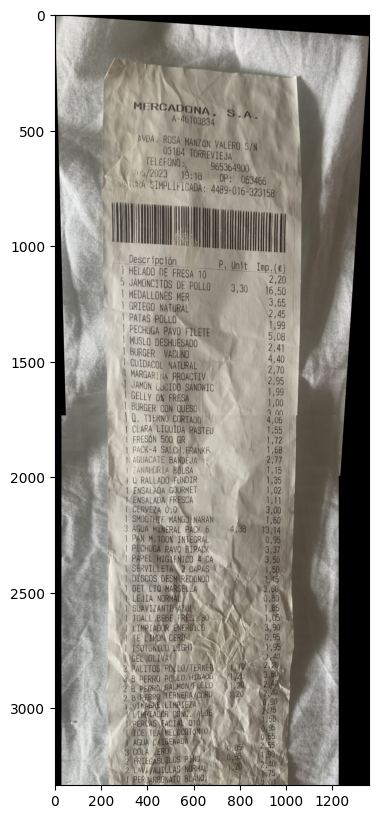

True

In [215]:
stitchedImage = stitchImages(base_image=part2_resized, sec_image=part1_resized, homography = H)
plot_image(stitchedImage)
cv.imwrite(result_file_name, stitchedImage)